In [4]:
#Import our dataset 
import pandas as pd
import numpy  as np
import time
from ucimlrepo import fetch_ucirepo 
from  sklearn.metrics import roc_curve

#fetch dataset 
mushroom = fetch_ucirepo(id = 73) 
#data as pd dataframe 
X = mushroom.data.features 
Y = mushroom.data.targets 

#Global Random State: 
rng = 1312

### General dataframe handling / pre-processing 

In [5]:
#counting number of each category
#print(X.groupby('cap-shape').count().reset_index())

#Check out the distribution of values in each column
#print((X['cap-shape']).value_counts()) 

#Do the same but for each column 
for name in X.columns: 
    print(X[name].value_counts()) 

#Plot them with plotly 
import plotly.express as px 
cap_counts = X['cap-shape'].value_counts()
fig = px.bar(x=cap_counts.index, y= cap_counts.values)
fig.show()

#Grouping data by some columns 
#print(X.groupby(by='edibility').count())

#Crostab table for frequenct distribution of 2+ variables 
twoby_tbl = pd.crosstab(index=X['cap-color'], columns = X['cap-surface']) 

#Pivot table for variable uses 

#pd.pivot_table(...)

#grouping by and counting only part of the df. usefull for large dfs. 
X.groupby(by= ['stalk-shape', 'stalk-root']).size() 
X.groupby(by= ['stalk-shape', 'stalk-root']).count()[['population', 'habitat', 'edibility']] 
X.groupby(by= ['stalk-shape', 'stalk-root'])[['population', 'habitat', 'edibility']].count() 

cap-shape
x    3656
f    3152
k     828
b     452
s      32
c       4
Name: count, dtype: int64
cap-surface
y    3244
s    2556
f    2320
g       4
Name: count, dtype: int64
cap-color
n    2284
g    1840
e    1500
y    1072
w    1040
b     168
p     144
c      44
u      16
r      16
Name: count, dtype: int64
bruises
f    4748
t    3376
Name: count, dtype: int64
odor
n    3528
f    2160
s     576
y     576
a     400
l     400
p     256
c     192
m      36
Name: count, dtype: int64
gill-attachment
f    7914
a     210
Name: count, dtype: int64
gill-spacing
c    6812
w    1312
Name: count, dtype: int64
gill-size
b    5612
n    2512
Name: count, dtype: int64
gill-color
b    1728
p    1492
w    1202
n    1048
g     752
h     732
u     492
k     408
e      96
y      86
o      64
r      24
Name: count, dtype: int64
stalk-shape
t    4608
e    3516
Name: count, dtype: int64
stalk-root
b    3776
e    1120
c     556
r     192
Name: count, dtype: int64
stalk-surface-above-ring
s    5176
k    2372
f

KeyError: "['edibility'] not in index"

In [ ]:
#Viewing the whole breadth of categories per variable 

pd.set_option('display.max_colwidth', None)

mushroom.variables['description']

0                                                                                                    None
1                                                    bell=b,conical=c,convex=x,flat=f, knobbed=k,sunken=s
2                                                                    fibrous=f,grooves=g,scaly=y,smooth=s
3                        brown=n,buff=b,cinnamon=c,gray=g,green=r, pink=p,purple=u,red=e,white=w,yellow=y
4                                                                                          bruises=t,no=f
5                            almond=a,anise=l,creosote=c,fishy=y,foul=f, musty=m,none=n,pungent=p,spicy=s
6                                                                attached=a,descending=d,free=f,notched=n
7                                                                             close=c,crowded=w,distant=d
8                                                                                        broad=b,narrow=n
9     black=k,brown=n,buff=b,chocolate=h,gray=

## Missing values 
It looks like stalk root has missing values, encoding with ? for missing stalk root is not the problem for missing values. 

In [6]:
X.isnull().values.any()
X.isnull().sum() 
#stalk-root has many missing values almost 1/3 of the total observations so we'll drop the variable.  
X_xn = X.drop('stalk-root',axis=1)  #X_xn:X without NAs
X_xn.isnull().sum() 

cap-shape                   0
cap-surface                 0
cap-color                   0
bruises                     0
odor                        0
gill-attachment             0
gill-spacing                0
gill-size                   0
gill-color                  0
stalk-shape                 0
stalk-surface-above-ring    0
stalk-surface-below-ring    0
stalk-color-above-ring      0
stalk-color-below-ring      0
veil-type                   0
veil-color                  0
ring-number                 0
ring-type                   0
spore-print-color           0
population                  0
habitat                     0
dtype: int64

### Variable encoding 

In [7]:
#Let's find them binary vars first
binaries =[] 
c=1
for name in X_xn.columns: 
    var_amount = (X[name].unique())
    
    if len(var_amount) == 2 : 
        binaries.append(name) 
        #print (c, name, var_amount) 
    c+=1
print(binaries)
#Only #4,8,10,23 apear as binaries. Only bruises and edibility are true binaries the rest just happen to have only two categories. 
#If we had different dataset the other features might had different "non-binary" values. 

#Dataset, without missing values, one-hot encoded
X_enc = pd.get_dummies(X_xn, columns=list(X_xn.columns), dtype = int )
#Dataset, with missing values but with one-hot encoding
X_all  = pd.get_dummies(X, columns = list(X.columns), dtype = int) 

#### Create encoding for the RF algo 
var_dict = {}
feature_cat_dict = {} # the desired dictionary
for line in enumerate(list(mushroom.variables['description'])[1:]): 
    var_dict[X.columns[line[0]]] = (str(line[1]).split(","))    # Create adictionary to know where everything came from 
    v_dct = {}                    #second_layer dict
    for cat in enumerate(line[1].split(',')):

        v_dct[str(cat[1]).split("=")[1]]=cat[0]
        
    feature_cat_dict[X.columns[line[0]]] = v_dct 

#Dataset with missing values, simple encoded. 
Xc=X    
for column in (Xc.columns): 
    Xc[column] = Xc[column].replace(to_replace=feature_cat_dict[column])
    #print(feature_cat_dict[column])

#Target variable label encoding 
Y=pd.DataFrame(Y)
Y.isnull().values.any()             #false 
Y.groupby(by =["poisonous"]).size() #only two categories poisonous or edible 
Y=Y.replace(to_replace = { "e" : "0", "p" : "1"} )
Y = np.ravel(Y)                 #returns a contiguous array of the same subtype as input with shape input.size 

['bruises', 'gill-attachment', 'gill-spacing', 'gill-size', 'stalk-shape']


/tmp/ipykernel_333910/884060922.py:35: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

/tmp/ipykernel_333910/884060922.py:35: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### ML_part 


In [8]:
#Split the data 
from sklearn.model_selection import train_test_split

#Dataset without missing values, one-hot encoded.  (kNN)
X_train,X_test, y_train, y_test = train_test_split(X_enc, Y , random_state = rng, test_size = 0.3 )

#Dataset with missing values, one-hot encoded. (Random forest)
Xme_train, Xme_test, yme_train, yme_test = train_test_split(X_all, Y, random_state = rng, test_size = 0.3 ) 

#Dataset with missing values, cat-encoding. (Ranfom Forest)
Xc_train, Xc_test, yc_train, yc_test = train_test_split(Xc, Y, random_state = rng, test_size = 0.3)


In [ ]:
#Initiate logfile
with open("result_log2.txt", "w") as f:
    f.write(" ")
    f.close()

## ROC curve plotting

In [2]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
def roc_plots(X_tests,y_tests,models,names,file=None):    #lists of test,validation datasets, model with parameters, names of the models 
    for  X_test, y_test, model,name in zip(X_tests, y_tests, models,names):
         
        y_pred = model.predict_proba(X_test)[:,1]
        fpr, tpr, thresholds = roc_curve(y_test.astype(int),y_pred.astype(int)) #thresholds is a byproduct...
        auc = round(roc_auc_score(y_test,y_pred),4)
        plt.plot(fpr,tpr, label = f'{name}, AUC=' + str(auc))
    plt.title('ROC curves for different classifiers', loc = 'left')
    plt.legend(loc = 'lower right')
    plt.savefig(file)

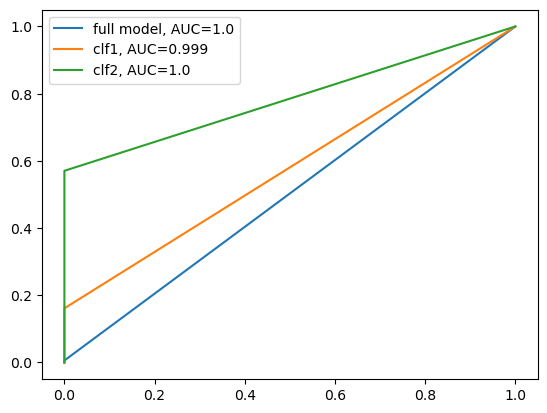

In [ ]:
y_pred = (clf_model.best_estimator_).predict_proba(Xc_test)[:, 1]
fpr, tpr, _ = roc_curve(yc_test.astype(int), y_pred.astype(int))
auc = round(roc_auc_score(yc_test, y_pred), 4)
plt.plot(fpr,tpr,label="full model, AUC="+str(auc))

y_pred = clf1.predict_proba(Xfl1_test)[:, 1]
fpr, tpr, _ = roc_curve(yfl1_test.astype(int), y_pred.astype(int))
auc = round(roc_auc_score(yfl1_test, y_pred), 4)
plt.plot(fpr,tpr,label="clf1, AUC="+str(auc))

y_pred = clf2.predict_proba(Xfl2_test)[:, 1]
fpr, tpr, _ = roc_curve(yfl2_test.astype(int), y_pred.astype(int))
auc = round(roc_auc_score(yfl2_test, y_pred), 4)
plt.plot(fpr,tpr,label="clf2, AUC="+str(auc))

plt.legend()

## Implementing Random Forest 
Since the estimator has native support for missing values, I'll use the X_m dataset. 

Tested initialy max_depth = 2 , 5 , 6 ,7 , 15. With max_depth = 7 we get already maximum accuracy

In [10]:
#Hyperparameter optimization with Random Search   #Here I choose the best parameters and based on that I do Feature importance plotting
import time
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV as RSCV
from sklearn.model_selection import GridSearchCV as GSCV
from sklearn.metrics import accuracy_score, recall_score , make_scorer, precision_score
start_time = time.time()
parameters_to_test = {'n_estimators' : np.arange(20, 50, 70), 
                      'max_depth' : [3, 5, 7, 9],
                      'max_features' : np.arange(0.1, 1), 
                      'max_samples' : [0.5, 0.7]}
cv = 5
scoring_d = {'accuracy' : make_scorer(accuracy_score),
            'reacll': make_scorer(recall_score)}

clf_model = RSCV(RandomForestClassifier(), parameters_to_test, n_iter = 20, cv = cv, scoring = scoring_d, refit = 'accuracy', n_jobs = -1)
clf_model.fit(Xc_train, yc_train)

clf_model_pred = clf_model.predict(Xc_test)
train_pred = clf_model.predict(Xc_train)
end_time = time.time()

print(f'Accuracy for model by RSCV: {accuracy_score(clf_model_pred,yc_test)}')
print(f'Accuracy for train data: {accuracy_score(train_pred,yc_train)}')
print(f'Test data: Recall: {round(recall_score(yc_test.astype(int),clf_model_pred.astype(int)),4)} , Precision: {round(precision_score(yc_test.astype(int),clf_model_pred.astype(int)),4)}')
print("Best parameters:", clf_model.best_params_)
print("Best CV score:", clf_model.best_score_)
print(f'Execution time: {round(end_time - start_time ,5)} sec')

with open ('result_log2.txt', 'a') as file: 
    file.write( f'First RF model\n'
                f'Accuracy for model by RSCV: {accuracy_score(clf_model_pred,yc_test)}\n'
                f'Accuracy for train data: {accuracy_score(train_pred,yc_train)}\n'
                f'Test data: Recall: {round(recall_score( yc_test.astype(int),clf_model_pred.astype(int)),4)} , Precision: {round(precision_score(yc_test.astype(int),clf_model_pred.astype(int)),4)}\n'
                f"Best parameters: {clf_model.best_params_}\n"
                f"Best CV score:  {clf_model.best_score_}\n"
                f'Execution time: {round(end_time - start_time ,5)} sec\n\n')
    file.close()

/home/todoritos/miniconda3/envs/omics/lib/python3.13/site-packages/sklearn/model_selection/_search.py:317: UserWarning:

The total space of parameters 8 is smaller than n_iter=20. Running 8 iterations. For exhaustive searches, use GridSearchCV.

/home/todoritos/miniconda3/envs/omics/lib/python3.13/site-packages/sklearn/model_selection/_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/todoritos/miniconda3/envs/omics/lib/python3.13/site-packages/sklearn/metrics/_scorer.py", line 152, in __call__
    score = scorer._score(
        cached_call, estimator, *args, **routed_params.get(name).score
    )
  File "/home/todoritos/miniconda3/envs/omics/lib/python3.13/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^

Accuracy for model by RSCV: 1.0
Accuracy for train data: 1.0
Test data: Recall: 1.0 , Precision: 1.0
Best parameters: {'n_estimators': np.int64(20), 'max_samples': 0.7, 'max_features': np.float64(0.1), 'max_depth': 9}
Best CV score: 1.0
Execution time: 23.09711 sec


In [11]:
#Hyperparameter optimization with Grid Search
import time
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV as GSCV


start_time = time.time()
parameters_to_test = {'n_estimators' : np.arange(50, 70, 100), 
                      'max_depth' : [3, 5, 7, 9],
                      'max_features' : np.arange(0.1, 1), 
                      'max_samples' : [0.5, 0.7]}

clf_model = GSCV(RandomForestClassifier(), parameters_to_test, cv = 5, scoring = 'accuracy', n_jobs = -1)
clf_model.fit(Xc_train, yc_train)

clf_model_pred = clf_model.predict(Xc_test)
train_pred = clf_model.predict(Xc_train)
end_time = time.time()

print(f'Accuracy for model by GSCV: {accuracy_score(clf_model_pred,yc_test)}')
print(f'Accuracy for train data: {accuracy_score(train_pred,yc_train)}')
print(f'Test data: Recall: {round(recall_score(yc_test.astype(int),clf_model_pred.astype(int)),4)} , Precision: {round(precision_score(yc_test.astype(int),clf_model_pred.astype(int)),4)}')

print(f"Best parameters: {clf_model.best_params_}")
print(f"Best CV score: {clf_model.best_score_}")
print(f'Execution time: {round(end_time - start_time ,5)} sec')

with open ('result_log2.txt', 'a') as file:
    file.write(f'Second RF model\n'
                f'Accuracy for model by GSCV: {accuracy_score(clf_model_pred,yc_test)}\n'
                f'Accuracy for train data: {accuracy_score(train_pred,yc_train)}\n'
                f'Test data: Recall: {round(recall_score(yc_test.astype(int),clf_model_pred.astype(int)),4)} , Precision: {round(precision_score(yc_test.astype(int),clf_model_pred.astype(int)),4)}\n'
                f"Best parameters: {clf_model.best_params_}\n"
                f"Best CV score: {clf_model.best_score_}\n"
                f'Execution time: {round(end_time - start_time ,5)} sec\n\n')
    file.close()

Accuracy for model by GSCV: 1.0
Accuracy for train data: 1.0
Test data: Recall: 1.0 , Precision: 1.0
Best parameters: {'max_depth': 7, 'max_features': np.float64(0.1), 'max_samples': 0.7, 'n_estimators': np.int64(50)}
Best CV score: 1.0
Execution time: 14.75923 sec


#### Feature importance and selection 
for the plotting check this too: https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-py


In [12]:
#Function 
import matplotlib.pyplot as plt 
def feat_importance_plot_mdi (DF,model,file=None) : #Feature Importance based on impurity
    feature_names = DF.columns
    
    importances = model.feature_importances_ 
    std = np.std([tree.feature_importances_ for tree in model.estimators_], axis = 0 ) 

    indices = np.argsort(importances)[::-1]
    print("Feature ranking:")
    for f in range(DF.shape[1]):
        print("%d.feature %d (*%s) :(%f)" % (f+1, indices[f], DF.columns[f], importances[indices[f]]))  

    #Plot the same values: 
    rf_importances = pd.Series(importances, index = feature_names) # beware which feature names to use 
    fig, ax = plt.subplots() 
    rf_importances.plot.bar(yerr = std, ax = ax) 
    ax.set_title("Feature importances using MDI")
    ax.set_ylabel("Mean decrease in impurity")
    fig.tight_layout()
    plt.savefig(file)

def feat_importance_plot_perm(DF, model, xtest, ytest, file=None) : #Feature importane plot based on permutation
    from sklearn.inspection import permutation_importance 
    feature_names = DF.columns
    start_time = time.time() 
    
    fibp = permutation_importance(model, xtest, ytest, n_repeats = 10,random_state = rng) 
    runtime = time.time() - start_time 
    print(f"Elapsed time to compute the permutation importances: {runtime:.3f} seconds") 
    rf_importances = pd.Series(fibp.importances_mean, index= feature_names)
    fig, ax = plt.subplots() 
    rf_importances.plot.bar(yerr = fibp.importances_std, ax = ax) 
    ax.set_title(f"Feature importances using permutation on full model.")
    ax.set_ylabel("Mean accuracy decrease ")
    fig.tight_layout() 
    plt.savefig(file)
    

Feature ranking:
1.feature 4 (*cap-shape) :(0.129770)
2.feature 19 (*cap-surface) :(0.124506)
3.feature 7 (*cap-color) :(0.085490)
4.feature 3 (*bruises) :(0.083584)
5.feature 10 (*odor) :(0.075518)
6.feature 18 (*gill-attachment) :(0.075252)
7.feature 11 (*gill-spacing) :(0.063968)
8.feature 20 (*gill-size) :(0.053737)
9.feature 8 (*gill-color) :(0.048306)
10.feature 6 (*stalk-shape) :(0.044065)
11.feature 21 (*stalk-root) :(0.042366)
12.feature 14 (*stalk-surface-above-ring) :(0.038305)
13.feature 12 (*stalk-surface-below-ring) :(0.026957)
14.feature 9 (*stalk-color-above-ring) :(0.020288)
15.feature 1 (*stalk-color-below-ring) :(0.019901)
16.feature 13 (*veil-type) :(0.016277)
17.feature 2 (*veil-color) :(0.014465)
18.feature 0 (*ring-number) :(0.013814)
19.feature 17 (*ring-type) :(0.013099)
20.feature 16 (*spore-print-color) :(0.006595)
21.feature 5 (*population) :(0.003736)
22.feature 15 (*habitat) :(0.000000)
Elapsed time to compute the permutation importances: 11.327 seconds


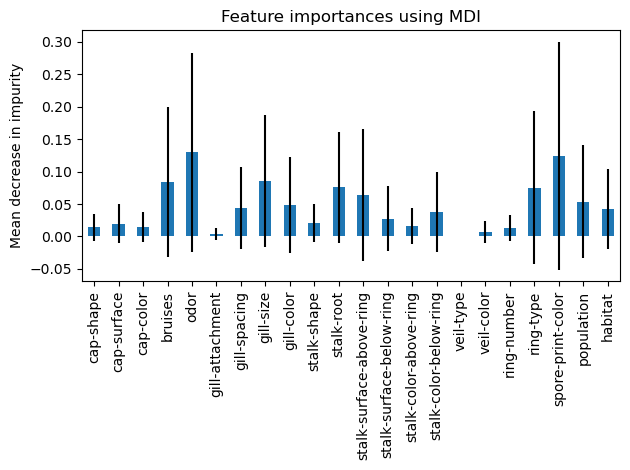

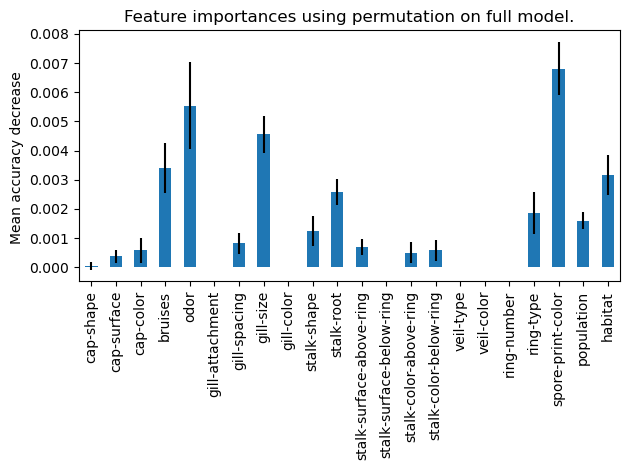

In [14]:
#Feature Importance 
feat_importance_plot_mdi(Xc, clf_model.best_estimator_,file='mdi_features.png')
feat_importance_plot_perm(Xc, clf_model.best_estimator_, Xc_test, yc_test, file='perm_features.png')

In [13]:
#Based on feature importance plotting I do compare efficacy of the full model vs model with selected features only. 
# -> Perm_importance odor, spore-print-color, gill-size, habitat, bruises
# -> Impurity : cap-shape, cap-color, cap-surface, odor, bruises 
import time 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score 


X_fless_mdi = Xc[['cap-shape','cap-color', 'cap-surface', 'odor', 'bruises']]
Xfl1_train, Xfl1_test, yfl1_train, yfl1_test = train_test_split(X_fless_mdi, Y, random_state = rng, test_size = 0.3)    #featureless1

X_fless_perm = Xc[['odor', 'spore-print-color', 'gill-size','habitat', 'bruises']]
Xfl2_train, Xfl2_test, yfl2_train, yfl2_test = train_test_split(X_fless_perm, Y, random_state = rng, test_size = 0.3)   #featureless2

#testing RF models with different parameters
clf1 = RandomForestClassifier(max_depth=7,max_features=0.1,max_samples=0.5,n_estimators=50)    #MDI
clf2 = RandomForestClassifier(max_depth=7,max_features=0.1,max_samples=0.5,n_estimators=50)    #PERM
#fitting the models to the data
start_time = time.time()
clf1.fit(Xfl1_train,yfl1_train)
clf2.fit(Xfl2_train,yfl2_train) 

#Try the cross validation process

scores_clf1 = cross_val_score(clf1, Xfl1_train, yfl1_train, cv = 5, scoring = 'accuracy')
scores_clf2 = cross_val_score(clf2, Xfl2_train, yfl2_train, cv = 5, scoring = 'accuracy')

#Predicting outcome for the test data 
clf1_pred = clf1.predict(Xfl1_test)
clf2_pred = clf2.predict(Xfl2_test) 
#Calculating different scores
clf1_test_score = accuracy_score(clf1_pred,yfl1_test)
clf2_test_score = accuracy_score(clf2_pred,yfl2_test)
#Recall
clf1_recall = recall_score(yfl1_test.astype(int),clf1_pred.astype(int))
clf2_recall = recall_score(yfl2_test.astype(int),clf2_pred.astype(int))
#Precision
clf1_precision = precision_score(yfl1_test.astype(int),clf1_pred.astype(int))
clf2_precision = precision_score(yfl2_test.astype(int),clf2_pred.astype(int)) 

end_time = time.time()
print(f"Score\nMDI: {scores_clf1} \n PERM: {scores_clf2}")
print(f"Mean accuracy Feature Reduction\nMDI: {round(scores_clf1.mean(),4)} PERM: {round(scores_clf2.mean(),4)}") 
print(f"Test Accuracy\nMDI: {round(clf1_test_score,4)} PERM: {round(clf2_test_score,4)}")
print(f"Test Recall; MDI: {round(clf1_recall,4)} PERM: {round(clf2_recall,4)}")
print(f"Precision; MDI: {round(clf1_precision,4)} PERM: {round(clf2_precision,4)}")
print(f'Execution time: {round(end_time - start_time ,5)} sec')

with open("result_log2.txt","a") as file: 
    file.write(f"RF classifier results after Feature selection based on importances\n"
        f"MDI variables: {X_fless_mdi.columns[0:]}\nPERM variables: {X_fless_perm.columns[0:]}\n"
        f"Score\nMDI: {scores_clf1} \n PERM: {scores_clf2}\n"
        f"Mean accuracy Feature Reduction\nMDI: {round(scores_clf1.mean(),4)} PERM: {round(scores_clf2.mean(),4)}\n"
        f"Test Accuracy\nMDI: {round(clf1_test_score,4)} PERM: {round(clf2_test_score,4)}\n"
        f"Test Recall; MDI: {round(clf1_recall,4)} PERM: {round(clf2_recall,4)}\n"
        f"Precision; MDI: {round(clf1_precision,4)} PERM: {round(clf2_precision,4)}\n"
        f'Execution time: {round(end_time - start_time ,5)} sec\n\n')
    file.close()


Score
MDI: [0.99209139 0.99560246 0.99560246 0.99648197 0.99648197] 
 PERM: [0.99912127 1.         1.         0.99736148 0.99824099]
Mean accuracy Feature Reduction
MDI: 0.9953 PERM: 0.9989
Test Accuracy
MDI: 0.9943 PERM: 0.9992
Test Recall; MDI: 0.9882 PERM: 0.9983
Precision; MDI: 1.0 PERM: 1.0
Execution time: 7.24768 sec


### ROC plot for all RF models

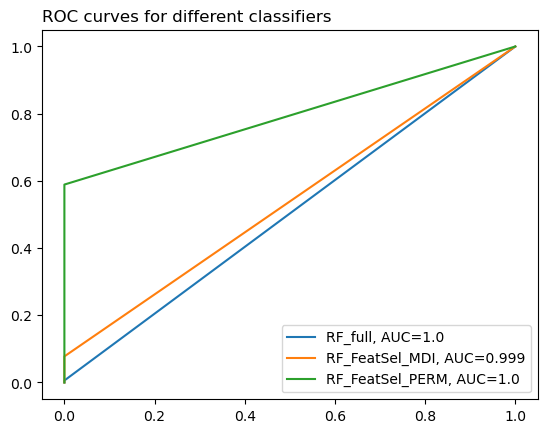

In [15]:
#ROC data for Random Forest and Random Forest after 2 different feature selections. 
#y_predictions,y_tests,models
#Adding Feature-less efficacy score to AUC plot: 
X_tsts = [Xc_test,Xfl1_test,Xfl2_test]
y_ts = [yc_test,yfl1_test,yfl2_test]
ms = [clf_model.best_estimator_,clf1,clf2] 
names = ['RF_full', 'RF_FeatSel_MDI', 'RF_FeatSel_PERM']
roc_plots(X_tsts,y_ts,ms,names,file='ROC_rf_models.png')

### Implementing k-Nearest Neighbors classification 
with Neighbor Component Analysis, non-supportive for missing values  

K = 2 : 100.00%		100.00%		100.00%		100.00%t	100.00%
K = 3 : 100.00%		100.00%		100.00%		100.00%t	100.00%
K = 4 : 100.00%		100.00%		100.00%		100.00%t	100.00%
K = 5 : 100.00%		100.00%		100.00%		100.00%t	100.00%
K = 6 : 100.00%		100.00%		100.00%		100.00%t	100.00%
K = 7 : 100.00%		100.00%		100.00%		100.00%t	100.00%
K = 8 : 99.98%		100.00%		100.00%		100.00%t	100.00%
K = 9 : 99.98%		100.00%		100.00%		100.00%t	100.00%
K = 10 : 99.98%		100.00%		99.99%		100.00%t	100.00%


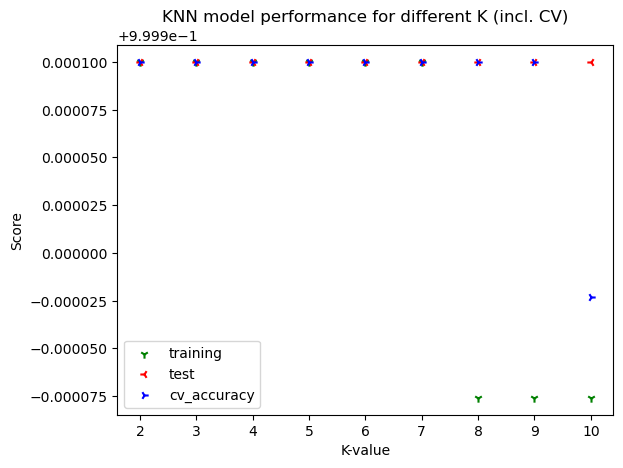

<Figure size 640x480 with 0 Axes>

In [16]:
#Finding the best K KNN
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.model_selection import KFold, cross_val_score
#Hyperparameter tuning
K = []
training = [] 
test = []
scores = {} 
accuracy = []
    # from cross validation
for k in range (2,11): 
    clsf = KNeighborsClassifier(n_neighbors=k) 
    clsf.fit(X_train, y_train) 

    training_score = clsf.score(X_train, y_train) 
    test_score = clsf.score(X_test, y_test) 
    training.append(training_score) 
    test.append(test_score) 
    K.append(k) 
    

    kf = KFold(n_splits = 5, shuffle = True, random_state = rng)        #Cross Validation over 5 splits. 
    cross_val_results = cross_val_score(KNeighborsClassifier(n_neighbors=k), X_enc, Y, cv = kf) 
    accuracy_cv = cross_val_results.mean()
    accuracy.append(accuracy_cv)
    
    accuracy_test = clsf.score(X_test, y_test) 
    ypred = clsf.predict(X_test)
    recall = recall_score(y_test.astype(int), ypred.astype(int))
    precision = precision_score(y_test.astype(int), ypred.astype(int))

    scores[k] = [training_score,test_score, accuracy_cv, precision , recall] 

#print("K \t training \t test \t C-V_mean_accuracy \tPrecision \tRecall")
#print(line)
with open('result_log2.txt',"a") as file:
    file.write(f"KNN model with CV\n"
        f"K \t training \t test \t C-V_mean_accuracy \tPrecision \tRecall\n")
    for key, value in scores.items() : 
        print(f"K = {key} : {value[0]*100:.2f}%\t\t{value[1]*100:.2f}%\t\t{value[2]*100:.2f}%\t\t{value[3]*100:.2f}%t\t{value[4]*100:.2f}%") 
        file.write(f"K = {key} : {value[0]*100:.2f}%\t\t{value[1]*100:.2f}%\t\t{value[2]*100:.2f}%\t\t{value[3]*100:.2f}%t\t{value[4]*100:.2f}%\n")
    file.write("\n\n")

#Plotting different K performances
import seaborn as sns 
import matplotlib.pyplot as plt 
plt.scatter(K,training, color ='g', label = 'training', marker = "1") 
plt.scatter(K,test, color = 'r', label = 'test', marker = "3") 
plt.scatter(K,accuracy, color = 'b', label = 'cv_accuracy', marker = "4")
plt.xlabel("K-value")
plt.ylabel("Score") 
plt.title("KNN model performance for different K (incl. CV)")
plt.legend()
plt.show() 
plt.savefig("KNN_model_performance_per_K.png")

In [17]:
#Finding the best K KNN with NCA and cross-validation 
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, KFold 
from sklearn.neighbors import NeighborhoodComponentsAnalysis as NCA

nca = NCA(random_state = rng) 

K= range(2,11) 
cv = KFold(n_splits  = 5, random_state = rng, shuffle = True) 
nca_scores = [] 

for k in K :
    model = Pipeline([
        ('nca', NCA(random_state=rng)),
        ('knn', KNeighborsClassifier(n_neighbors = k ) ) ]) 

    scores = cross_val_score (model, X_train, y_train, cv = cv, scoring = 'accuracy') 
    model.fit(X_train,y_train)
    #As scoraroume
    accuracy_test = model.score(X_test, y_test) 
    ypred = model.predict(X_test) 
    recall = recall_score(y_test.astype(int), ypred.astype(int))
    precision = precision_score(y_test.astype(int), ypred.astype(int))
    print(f"Mean CV accuracy(train) \tAccuracy score (test) \tPrecision \tRecall") 
    print(f"K={k}:\t\t{scores.mean()*100:.3f}%\t\t{accuracy_test * 100:.3f}%\t\t{precision *100:.3f}%\t\t{recall *100:.3f}%")
    nca_scores.append(scores.mean()) 
    with open('result_log.txt','a') as file: 
        file.write(f"kNN model NCA CV"
                    f"Mean CV accuracy(train) \tAccuracy score (test) \tPrecision \tRecall\n"
                    f"K={k}:\t\t{scores.mean()*100:.3f}%\t\t{accuracy_test * 100:.3f}%\t\t{precision *100:.3f}%\t\t{recall *100:.3f}%\n\n")
        file.close()


Mean CV accuracy(train) 	Accuracy score (test) 	Precision 	Recall
K=2:		100.000%		100.000%		100.000%		100.000%
Mean CV accuracy(train) 	Accuracy score (test) 	Precision 	Recall
K=3:		100.000%		100.000%		100.000%		100.000%
Mean CV accuracy(train) 	Accuracy score (test) 	Precision 	Recall
K=4:		99.965%		100.000%		100.000%		100.000%
Mean CV accuracy(train) 	Accuracy score (test) 	Precision 	Recall
K=5:		99.965%		100.000%		100.000%		100.000%
Mean CV accuracy(train) 	Accuracy score (test) 	Precision 	Recall
K=6:		99.930%		100.000%		100.000%		100.000%
Mean CV accuracy(train) 	Accuracy score (test) 	Precision 	Recall
K=7:		99.965%		100.000%		100.000%		100.000%
Mean CV accuracy(train) 	Accuracy score (test) 	Precision 	Recall
K=8:		99.930%		99.877%		100.000%		99.747%
Mean CV accuracy(train) 	Accuracy score (test) 	Precision 	Recall
K=9:		99.965%		99.877%		100.000%		99.747%
Mean CV accuracy(train) 	Accuracy score (test) 	Precision 	Recall
K=10:		99.965%		99.877%		100.000%		99.747%


In [18]:
#Model implementation kNN for the chosen K
import time
clsf_knn = KNeighborsClassifier(n_neighbors=3) 
clsf.fit(X_train, y_train) 
training_score = clsf.score(X_train, y_train) 
test_score = clsf.score(X_test, y_test) 
pred_knn = clsf.predict(X_test) 

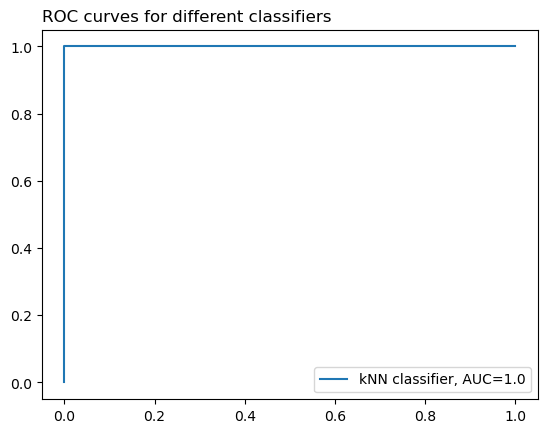

In [20]:
 
roc_plots([X_test],[y_test],[clsf_knn.fit(X_train,y_train)],['kNN classifier'], file='kNN_classifier.png')

## ROC for all models 

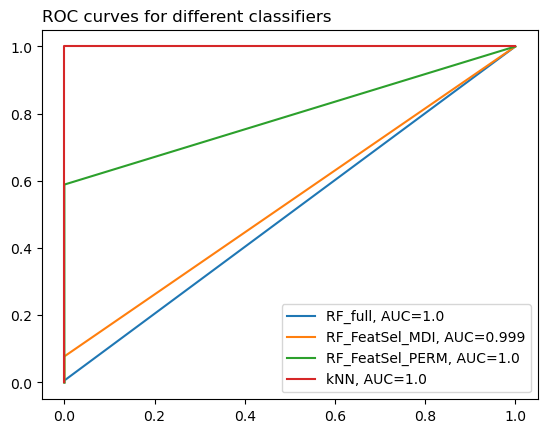

In [21]:
X_tsts = [Xc_test,Xfl1_test,Xfl2_test,X_test]
y_ts = [yc_test,yfl1_test,yfl2_test,y_test]
ms = [clf_model.best_estimator_,clf1,clf2,clsf_knn.fit(X_train,y_train)] 
names = ['RF_full', 'RF_FeatSel_MDI', 'RF_FeatSel_PERM','kNN']
roc_plots(X_tsts,y_ts,ms,names,file='roc_all_classifiers.png')

Unused stuff

In [ ]:
#Finding the best K KNN with NCA
from sklearn.neighbors import NeighborhoodComponentsAnalysis as NCA
K2 = []

nca_scores = [] 
test2 = []
scores2 = {}

nca = NCA(random_state = rng) 
nca.fit(X_train, y_train) 

for k in range(2,11): 
    knn = KNeighborsClassifier(n_neighbors = k) 
    knn.fit(X_train, y_train) 
    score = knn.score(X_test,y_test) 

    knn.fit(nca.transform(X_train), y_train)
    nca_score = knn.score(nca.transform(X_test),y_test) 

    K.append(k)
    nca_scores.append(nca_score)
    test2.append(score) 

    scores2[k] = [score, nca_score] 
    
print("K \tKNN_score \tKNN_NCA_score")
for key, value in scores2.items(): 

    print(f"K = {key} :\t\t{value[0]*100:.3f}%\t\t{value[1]*100:.3f}%")